# Model Agnostic Analysis

## Introduction

In this tutorial model agnostic analysis means writing your notebook so that it can easily be used with any CF compliant data source.

### What are the CF Conventions?

From [CF Metadata conventions](https://cfconventions.org):

> The CF metadata conventions are designed to promote the processing and sharing of files created with the NetCDF API. The conventions define metadata that provide a definitive description of what the data in each variable represents, and the spatial and temporal properties of the data. This enables users of data from different sources to decide which quantities are comparable, and facilitates building applications with powerful extraction, regridding, and display capabilities. The CF convention includes a standard name table, which defines strings that identify physical quantities.

In most cases the model output data accessed through the COSIMA Cookbook complies with some version of the CF conventions, enough to be usable for model agnostic analysis.

### Why bother?

Model agnostic means the same code can work for multiple models. This makes your code more usable by **you** and by others. You no longer need to have different versions of code for different models. It makes you and any one who uses your code more productive. It allows for common tasks to be abstracted into general methods that can be more easily reused, meaning less code needs to be written and maintained. This is an enormous produtivity boost.

### How is model agnostic analysis achieved?

This can be achieved by using packages that enable this:
- [cf_xarray](https://cf-xarray.readthedocs.io/en/latest/index.html) for generalised coordinate naming
- [xgcm](https://xgcm.readthedocs.io) to make grid operations generic across data
- [pint](https://pint.readthedocs.io/) and [pint-xarray](https://pint-xarray.readthedocs.io/) for handling units easily and robustly

## Example

### Introduction

This example uses an example analysis, shows how the this might be done in a traditional, model specific, manner, and then implements the same analysis in a model agnostic way.

First step is to import necessary libaries.

In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import cf_xarray as cfxr
import pint_xarray
from pint import application_registry as ureg
import cf_xarray.units
import cmocean as cm
import cartopy.crs as ccrs
import cartopy.feature as cft

cf_xarray works best when xarray keeps attributes by default.

In [2]:
xr.set_options(keep_attrs=True);

Load a dataset using COSIMA Cookbook, so first open a session to the default database

In [3]:
session = cc.database.create_session()

Now load surface temperature data from a 0.25$^\circ$ global MOM5 model

In [4]:
experiment = '025deg_jra55v13_iaf_gmredi6'
variable = 'surface_temp'
SST = cc.querying.getvar(experiment, variable, session, frequency='1 monthly', n=12)

This is a 3D dataset in latitude, longitude and time:

In [5]:
SST

<xarray.DataArray 'surface_temp' (time: 288, yt_ocean: 1080, xt_ocean: 1440)>
dask.array<concatenate, shape=(288, 1080, 1440), dtype=float32, chunksize=(1, 540, 720), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.9 -279.6 -279.4 ... 79.38 79.62 79.88
  * yt_ocean  (yt_ocean) float64 -81.08 -80.97 -80.87 ... 89.74 89.84 89.95
  * time      (time) datetime64[ns] 1958-01-14T12:00:00 ... 1981-12-14T12:00:00
Attributes:
    long_name:      Conservative temperature
    units:          deg_C
    valid_range:    [-10. 500.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    coordinates:    geolon_t geolat_t
    ncfiles:        ['/g/data/hh5/tmp/cosima/access-om2-025/025deg_jra55v13_i...

### Model specific

First do this as it might usually be done, in a model specific manner:

1. Use the time coordinate name in the mean function
2. Subtract a hard-coded value to convert the temperature degrees celcius from degrees Kelvin (the meta-data says the units are `deg_C` but this is clearly incorrect)

In [6]:
SST_time_mean = SST.mean('time') - 273.15
SST_time_mean

<xarray.DataArray 'surface_temp' (yt_ocean: 1080, xt_ocean: 1440)>
dask.array<sub, shape=(1080, 1440), dtype=float32, chunksize=(540, 720), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.9 -279.6 -279.4 ... 79.38 79.62 79.88
  * yt_ocean  (yt_ocean) float64 -81.08 -80.97 -80.87 ... 89.74 89.84 89.95
Attributes:
    long_name:      Conservative temperature
    units:          deg_C
    valid_range:    [-10. 500.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    coordinates:    geolon_t geolat_t
    ncfiles:        ['/g/data/hh5/tmp/cosima/access-om2-025/025deg_jra55v13_i...

Now plot the result

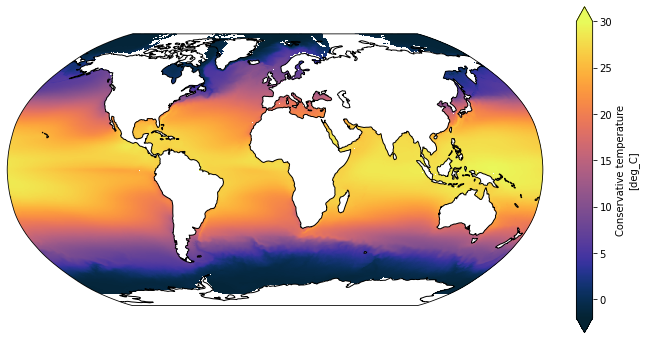

In [7]:
plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.Robinson())

SST_time_mean.plot(ax=ax,
                   x='xt_ocean', y='yt_ocean', 
                   transform=ccrs.PlateCarree(),
                   vmin=-2, vmax=30, extend='both',
                   cmap=cm.cm.thermal)

ax.coastlines();

Note that the arctic is not correctly respresented due to the 1D lat/lon coordinates not being correct in the tripole area. See the [Making Maps with cartopy Tutorial](https://cosima-recipes.readthedocs.io/en/latest/tutorials/Making_Maps_with_Cartopy.html#fixing-the-tripole) for more information.

### Model agnostic

Now do the same calculation in a model agnostic manner

For this data it is necessary to correct the units attribute first. This shouldn't be necessary if the metadata is correct

In [8]:
SST.attrs['units'] = 'K'

Now use `pint` to ensure this is in degrees C. Note that if the data was originally in degrees celcius this would be fine, it would do nothing. So this is a way of catering for any temperature units that are understood by `pint` in a transparent way. Note the call to `quantify` which invokes `pint`'s machinery to parse the units and allow unit conversions.

In [9]:
SST = SST.pint.quantify().pint.to('C')

In [10]:
SST

<xarray.DataArray 'surface_temp' (time: 288, yt_ocean: 1080, xt_ocean: 1440)>
<Quantity(dask.array<truediv, shape=(288, 1080, 1440), dtype=float32, chunksize=(1, 540, 720), chunktype=numpy.ndarray>, 'degree_Celsius')>
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.9 -279.6 -279.4 ... 79.38 79.62 79.88
  * yt_ocean  (yt_ocean) float64 -81.08 -80.97 -80.87 ... 89.74 89.84 89.95
  * time      (time) datetime64[ns] 1958-01-14T12:00:00 ... 1981-12-14T12:00:00
Attributes:
    long_name:      Conservative temperature
    valid_range:    [-10. 500.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    coordinates:    geolon_t geolat_t
    ncfiles:        ['/g/data/hh5/tmp/cosima/access-om2-025/025deg_jra55v13_i...

Now take the time mean, but this time use the `cf` accessor to automatically determine the name of the time dimension. `cf_xarray` checks the names of variables and coordinates, and associated metadata to try and infer information about the data based on the CF conventions.

To see what `cf_xarray` information is available just evaluate the accessor:

In [11]:
SST.cf

Coordinates:
- CF Axes: * X: ['xt_ocean']
           * Y: ['yt_ocean']
           * T: ['time']
             Z: n/a

- CF Coordinates: * longitude: ['xt_ocean']
                  * latitude: ['yt_ocean']
                  * time: ['time']
                    vertical: n/a

- Cell Measures:   area, volume: n/a

- Standard Names:   n/a

- Bounds:   n/a

In this case it has found `X`, `Y` and `T` axes, and `longitude`, `latitude` and `time` axes. These are now accessible like a `dict` using the `cf` accessor. Note that this returns the actual coordinate, and many functions just want a simple string argument, which is the name of the coordinate.

`cf_xarray` also wraps many standard xarray functions allowing `cf` names to be used, which are [automatically converted to the name in the data](https://cf-xarray.readthedocs.io/en/latest/examples/introduction.html#feature-rewriting-arguments). 

The upshot: just use the `cf` accessor and then append the required function and use the standard CF coordinate name (in this case they are the same, `time`, but that is not guaranteed)

In [12]:
SST_time_mean = SST.cf.mean('time')
SST_time_mean

<xarray.DataArray 'surface_temp' (yt_ocean: 1080, xt_ocean: 1440)>
<Quantity(dask.array<mean_agg-aggregate, shape=(1080, 1440), dtype=float32, chunksize=(540, 720), chunktype=numpy.ndarray>, 'degree_Celsius')>
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.9 -279.6 -279.4 ... 79.38 79.62 79.88
  * yt_ocean  (yt_ocean) float64 -81.08 -80.97 -80.87 ... 89.74 89.84 89.95
Attributes:
    long_name:      Conservative temperature
    valid_range:    [-10. 500.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    coordinates:    geolon_t geolat_t
    ncfiles:        ['/g/data/hh5/tmp/cosima/access-om2-025/025deg_jra55v13_i...

Using the `cf_xarray` wrapped function makes the code more legible and easier to write, i.e.
```python
SST.cf.mean('time')
```
compared to
```python
SST.mean(SST.cf['time'].name)
```

In the same way the `cf` accessor can be used in the plot and the CF names for latitude and longitude used as `x` and `y` arguments

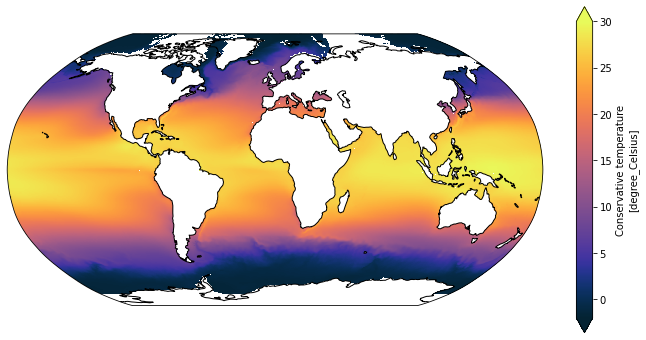

In [13]:
plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.Robinson())

SST_time_mean.cf.plot(ax=ax,
                      x='longitude', y='latitude', 
                      transform=ccrs.PlateCarree(),
                      vmin=-2, vmax=30, extend='both',
                      cmap=cm.cm.thermal)

ax.coastlines();

## Putting this into practice

Above a model agnostic version of some code was demonstrated, but that doesn't utilise the full power of what it is capable of. The model agnostic code can now be easily turned into a function that accepts an xarray DataArray:

In [14]:
def plot_global_temp_in_degrees_celcius(da):
    # Take the time mean of da and plot a global temperature field in a Robinson projection
    # 
    # Input DataArray (da) should be a 3D array of latitude, longitude and time.
    
    da = da.pint.quantify().pint.to('C')
    da_time_mean = da.cf.mean('time')
    
    plt.figure(figsize=(12, 6))
    ax = plt.axes(projection=ccrs.Robinson())

    da_time_mean.cf.plot(ax=ax,
                         x='longitude', y='latitude', 
                         transform=ccrs.PlateCarree(),
                         vmin=-2, vmax=30, extend='both',
                         cmap=cm.cm.thermal)

    ax.coastlines();

Try it out with the SST data used above

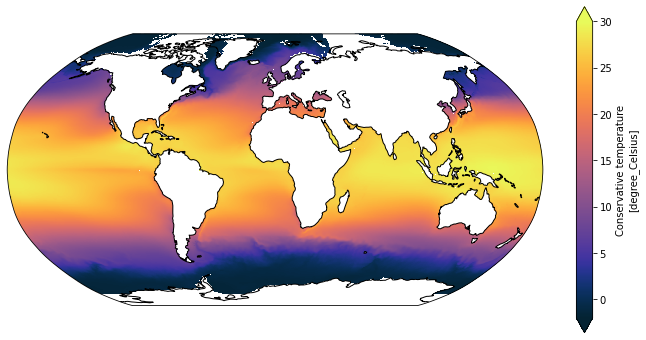

In [15]:
plot_global_temp_in_degrees_celcius(SST)

Ok, so now try on the output from a different experiment and model (MOM6):

In [16]:
experiment = 'OM4_025.JRA_RYF'
variable = 'tos'
SST_mom6 = cc.querying.getvar(experiment, variable, session, frequency='1 monthly', n=12)

In [17]:
SST_mom6

<xarray.DataArray 'tos' (time: 144, yh: 1080, xh: 1440)>
dask.array<concatenate, shape=(144, 1080, 1440), dtype=float32, chunksize=(1, 540, 720), chunktype=numpy.ndarray>
Coordinates:
  * xh       (xh) float64 -299.7 -299.5 -299.2 -299.0 ... 59.53 59.78 60.03
  * yh       (yh) float64 -80.39 -80.31 -80.23 -80.15 ... 89.73 89.84 89.95
  * time     (time) object 1900-01-16 12:00:00 ... 1911-12-16 12:00:00
Attributes:
    units:          degC
    long_name:      Sea Surface Temperature
    cell_methods:   area:mean yh:mean xh:mean time: mean
    cell_measures:  area: areacello
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_surface_temperature
    ncfiles:        ['/g/data/ik11/outputs/mom6-om4-025/OM4_025.JRA_RYF/outpu...
    contact:        Andy Hogg
    email:          Andy.Hogg@anu.edu.au
    created:        2021-11-01
    description:    0.25 degree OM4 (MOM6+SIS2) global model configuration un...

Check to see it has correctly parsed the CF information. It is not necessary to print this out, but interesting, and note it has quite different index and coordinate names

In [18]:
SST_mom6.cf

Coordinates:
- CF Axes: * X: ['xh']
           * Y: ['yh']
           * T: ['time']
             Z: n/a

- CF Coordinates: * longitude: ['xh']
                  * latitude: ['yh']
                  * time: ['time']
                    vertical: n/a

- Cell Measures:   area, volume: n/a

- Standard Names:   n/a

- Bounds:   n/a

Use the function from above which also worked on MOM5 data with very different coordinates

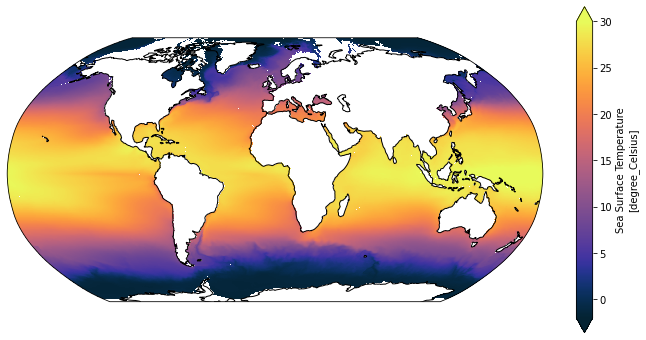

In [19]:
plot_global_temp_in_degrees_celcius(SST_mom6)

## What to do when it goes wrong

The model agnostic function worked flawlessly with two different ocean data sets, after the units were corrected in the MOM5 data. What about some ice data?

Using the same experiment from which the first `SST` data was obtained, load the ice air temperature variable

In [20]:
experiment = '025deg_jra55v13_iaf_gmredi6'
variable = 'Tair_m'
ice_air_temp = cc.querying.getvar(experiment, variable, session, frequency='1 monthly', n=12)

In [21]:
ice_air_temp

<xarray.DataArray 'Tair_m' (time: 12, nj: 1080, ni: 1440)>
dask.array<concatenate, shape=(12, 1080, 1440), dtype=float32, chunksize=(1, 1080, 1440), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1958-02-01 1958-03-01 ... 1959-01-01
    TLON     (nj, ni) float32 dask.array<chunksize=(1080, 1440), meta=np.ndarray>
    TLAT     (nj, ni) float32 dask.array<chunksize=(1080, 1440), meta=np.ndarray>
    ULON     (nj, ni) float32 dask.array<chunksize=(1080, 1440), meta=np.ndarray>
    ULAT     (nj, ni) float32 dask.array<chunksize=(1080, 1440), meta=np.ndarray>
Dimensions without coordinates: nj, ni
Attributes:
    units:          C
    long_name:      air temperature
    cell_measures:  area: tarea
    cell_methods:   time: mean
    time_rep:       averaged
    ncfiles:        ['/g/data/hh5/tmp/cosima/access-om2-025/025deg_jra55v13_i...

And try the generic routine

KeyError: "Receive multiple variables for key 'longitude': ['ULON', 'TLON']. Expected only one. Please pass a list ['longitude'] instead to get all variables matching 'longitude'."

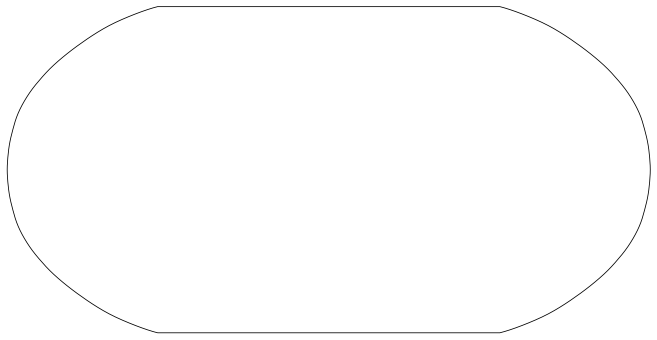

In [22]:
plot_global_temp_in_degrees_celcius(ice_air_temp)

The error message is
```
"Receive multiple variables for key 'longitude': ['TLON', 'ULON']. Expected only one. Please pass a list ['longitude'] instead to get all variables matching 'longitude'."
```
This suggests that `cf_xarray` has found multiple longitude coordinates `TLON` and `ULON` and doesn't know how to resolve this automatically. 

Inspecting the `cf` information doesn't show multiple axes like it [does in the documentation](https://cf-xarray.readthedocs.io/en/latest/examples/introduction.html#what-attributes-have-been-discovered):

In [23]:
ice_air_temp.cf

Coordinates:
- CF Axes:   X, Y, Z, T: n/a

- CF Coordinates:   longitude: ['TLON']
                    latitude: ['TLAT']
                    vertical, time: n/a

- Cell Measures:   area, volume: n/a

- Standard Names:   n/a

- Bounds:   n/a

[This is a bug](https://github.com/xarray-contrib/cf-xarray/issues/396), taking the mean alters the coordinates:

In [24]:
ice_air_temp.cf.mean('time').cf

Coordinates:
- CF Axes:   X, Y, Z, T: n/a

- CF Coordinates:   longitude: ['TLON', 'ULON']
                    latitude: ['TLAT', 'ULAT']
                    vertical, time: n/a

- Cell Measures:   area, volume: n/a

- Standard Names:   n/a

- Bounds:   n/a

So the solution is to drop the redundant velocity grid:

In [25]:
ice_air_temp = ice_air_temp.drop_vars(['ULON', 'ULAT'])

Now trying to plot again using the generic function and there is another error:

ValueError: x and y arguments to pcolormesh cannot have non-finite values or be of type numpy.ma.core.MaskedArray with masked values

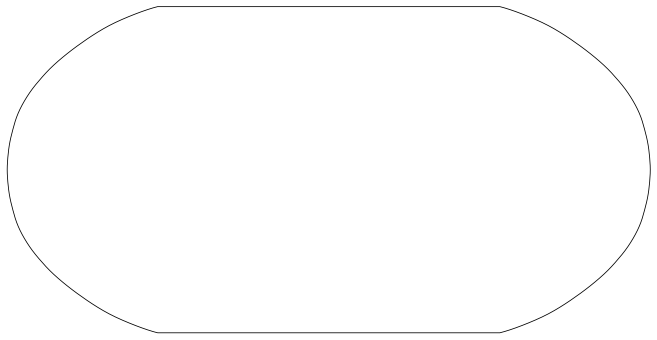

In [26]:
plot_global_temp_in_degrees_celcius(ice_air_temp)

This error:
```
ValueError: x and y arguments to pcolormesh cannot have non-finite values or be of type numpy.ma.core.MaskedArray with masked values
```
is because there are `NaN`'s in the coordinate variables, as [explained in the plotting with cartopy tutorial](https://cosima-recipes.readthedocs.io/en/latest/tutorials/Making_Maps_with_Cartopy.html#fixing-the-tripole).

By following the instructions in that tutorial and the [Spatial selection with tripolar ACCESS-OM2 grid notebook](https://cosima-recipes.readthedocs.io/en/latest/documented_examples/Spatial_selection.html#gallery-documented-examples-spatial-selection-ipynb) the coordinates can be fixed by replacing them with coordinates from the ice grid input file. It requires some work, the dimensions must be renamed to match, and coordinates converted from radians to degrees.

In [27]:
ice_grid = xr.open_dataset('/g/data/ik11/inputs/access-om2/input_eee21b65/cice_025deg/grid.nc').rename({'ny': 'nj', 'nx': 'ni'})
ice_grid = ice_grid.pint.quantify()

ice_air_temp = ice_air_temp.assign_coords({'TLON': ice_grid.tlon.pint.to('degrees_E'), 'TLAT': ice_grid.tlat.pint.to('degrees_N')})
ice_air_temp

<xarray.DataArray 'Tair_m' (time: 12, nj: 1080, ni: 1440)>
dask.array<concatenate, shape=(12, 1080, 1440), dtype=float32, chunksize=(1, 1080, 1440), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1958-02-01 1958-03-01 ... 1959-01-01
    TLON     (nj, ni) float64 [degrees_east] -279.9 -279.6 -279.4 ... 80.0 80.0
    TLAT     (nj, ni) float64 [degrees_north] -81.08 -81.08 ... 65.13 65.03
Dimensions without coordinates: nj, ni
Attributes:
    units:          C
    long_name:      air temperature
    cell_measures:  area: tarea
    cell_methods:   time: mean
    time_rep:       averaged
    ncfiles:        ['/g/data/hh5/tmp/cosima/access-om2-025/025deg_jra55v13_i...

Finally, the generic plotting routine works

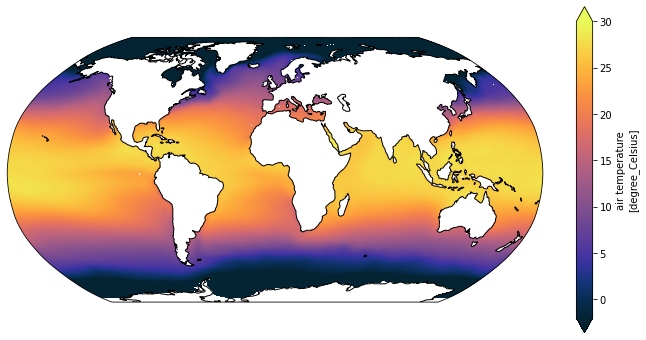

In [28]:
plot_global_temp_in_degrees_celcius(ice_air_temp)

One more step is to modify the original routine to take the vertical range as an argument, so it is more generally useful:

In [29]:
def plot_global_temp_in_degrees_celcius(da, vmin=-2, vmax=30):
    # Take the time mean of da and plot a global temperature field in a Robinson projection
    # 
    # Input DataArray (da) should be a 3D array of latitude, longitude and time.
    
    da = da.pint.quantify().pint.to('C')
    da_time_mean = da.cf.mean('time')
    
    plt.figure(figsize=(12, 6))
    ax = plt.axes(projection=ccrs.Robinson())

    da_time_mean.cf.plot(ax=ax,
                         x='longitude', y='latitude', 
                         transform=ccrs.PlateCarree(),
                         vmin=vmin, vmax=vmax, extend='both',
                         cmap=cm.cm.thermal)

    ax.coastlines();

By specifying default values for the arguments it is completely backwards compatible, we have lost no functionality, but the ice air temperature can now be plotted with a range that better suits the range of the data

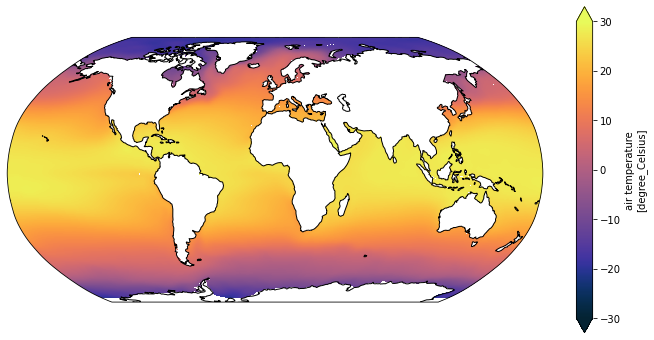

In [30]:
plot_global_temp_in_degrees_celcius(ice_air_temp, vmin=-30)

## Conclusion

Model specific code to take a time mean and plot the data was converted to a model agnostic function with no loss of functionality.

The same function can be used with a wide range CF compliant data.

In some cases the input data will need to be modified if it is not sufficiently compliant, or non-conforming in some way, such as the ice data above with `NaN`'s in the coordinate. It is better to modify the data to be more compliant and higher quality, and use generic tools, than have multiple code versions to account for the vagaries or problems with individual datasets. 

Ideally those improvements can be incorporated into future versions of the data at source, in post-processing, or in some utility functions for transforming a class of non-conforming data.